The aim of this notebook is to generate the 22 pairs of datasets from 2000 from 2021 using the expanding window method. Later, store those datasets to ease the use and reduce time consumption.

# 1. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Typicals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
import chardet
import pickle
import math
from scipy.stats import ttest_1samp

# Options
pd.set_option('display.max_columns', 100)

# SKlearn
    # Pipeline
from sklearn.pipeline import Pipeline

    # Preprocessing
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import mutual_info_regression, SelectKBest

    # Models
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

    # Metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import f1_score,roc_auc_score,roc_curve

# 2. Filtering the data set

1. Delete all instances where target>10.000 and set the maximum target=1.000. Delete target when target < 0.001.

2. Delete instances that contain more than 40% of NAN.

3. Delete companies that have less than three years in the dataset.

4. Delete columns where more than 40 % of the features are NANs.

5. Replace +-inf with np.nan

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])
sp500_list = sp500_list.tolist()

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')
df1 = df1[df1['Ticker'].isin(sp500_list)]

# Drop the index column
df1.drop('Unnamed: 0', axis=1, inplace=True)
print(df1.shape)

## 0. Deleting rows with np.nan in 'target'
df1 = df1.dropna(subset=['target'])
print(df1.shape)

## 1. Delete large instances
# Deleting rows where 'Feature' is greater than 10000
df2 = df1[df1['target'] <= 10000]

# Modifying values in 'Feature' column between 1000 and 10000
df2.loc[(df2['target'] >= 1000) & (df2['target'] <= 10000), 'target'] = 1000
print(df2.shape)

## 2. Delete instances where more than 40% are NAN
# Set the threshold
threshold_column = int(len(df2.columns)*0.60)

df3 = df2.dropna(thresh=threshold_column)
print(df3.shape)

## 3. Delete companies that has less than three years in the dataset
# Counting occurrences of each category
counts = df3['Ticker'].value_counts()

# Filtering rows based on category counts
df4 = df3[df3['Ticker'].map(counts) > 3]
print(df4.shape)

## 4. Delete instances where more than 40 % of the features are NANs.
# Set the threshold
threshold_row = int(len(df2)*0.60)

# Deleting columns with more than 40% NaN values
df5 = df4.dropna(axis=1, thresh=threshold_row)
print(df5.shape)

## 5. Replace infinity values with NaN
df5.replace([np.inf, -np.inf], np.nan, inplace=True)

(10211, 74)
(9826, 74)
(9826, 74)
(9795, 74)
(9784, 74)
(9784, 71)


<ipython-input-5-beb930e4c9d3>:1: DtypeWarning: Columns (10,13,16,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')
<ipython-input-5-beb930e4c9d3>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
features = df5.columns
features

Index(['year', 'Ticker', 'Industry', 'Sector', 'price', 'price_adjusted',
       'price_diff1', 'price_diff1.1', 'market_cap', 'eps', 'eps_diff1',
       'eps_dif2', 'per', 'per_diff1', 'per_diff2', 'der', 'der_diff1',
       'der_diff2', 'wcr', 'wcr_diff1', 'wcr_diff2', 'qr', 'qr_diff1',
       'qr_diff2', 'fcfps', 'fcfps_diff1', 'fcfps_diff2', 'pcfr', 'pcfr_diff1',
       'pcfr_diff2', 'totalAssets', 'intangibleAssets', 'otherCurrentAssets',
       'totalLiab', 'otherCurrentLiab', 'beginPeriodCashFlow',
       'endPeriodCashFlow', 'totalCashFromOperatingActivities', 'changeInCash',
       'changeInWorkingCapital', 'freeCashFlow', 'incomeBeforeTax',
       'netIncome_x', 'sellingGeneralAdministrative', 'grossProfit', 'ebit',
       'ebitda', 'depreciationAndAmortization', 'operatingIncome',
       'totalOperatingExpenses', 'totalRevenue', 'costOfRevenue',
       'dividendsPaid', 'commonStockSharesOutstanding',
       'Dif 3-Month Treasury Bill: Secondary Market Rate',
       'Dif 10-Y

In [ ]:
df5.describe(include='all')

,year,Ticker,Industry,Sector,price,price_adjusted,price_diff1,price_diff1.1,market_cap,eps,eps_diff1,eps_dif2,per,per_diff1,per_diff2,der,der_diff1,der_diff2,wcr,wcr_diff1,wcr_diff2,qr,qr_diff1,qr_diff2,fcfps,fcfps_diff1,fcfps_diff2,pcfr,pcfr_diff1,pcfr_diff2,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,otherCurrentLiab,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,changeInCash,changeInWorkingCapital,freeCashFlow,incomeBeforeTax,netIncome_x,sellingGeneralAdministrative,grossProfit,ebit,ebitda,depreciationAndAmortization,operatingIncome,totalOperatingExpenses,totalRevenue,costOfRevenue,dividendsPaid,commonStockSharesOutstanding,Dif 3-Month Treasury Bill: Secondary Market Rate,Dif 10-Year Treasury Constant Maturity Rate,3-Month Treasury Bill: Secondary Market Rate,10-Year Treasury Constant Maturity Rate,dif_unemployment_rate_proc,unemployment_rate_proc,dif_employment_proc,employment_proc,dif_money_supply_proc,money_supply_proc,dif_inflation_rate_proc,inflation_rate_proc,dif_us_gdp_proc,us_gdp_proc,dif_us_population_proc,us_population_proc,target
count,9784.000000,9784,9784,9784,9784.000000,9784.000000,9438.000000,9064.000000,9784.000000,9780.00,9432.000000,9057.000000,9780.00,9432.000000,9057.000000,9071,8689.000000,8314.000000,8750,8360.000000,7985.000000,7319,6914.000000,6648.000000,9771.000000,9418.000000,9042.000000,9771.000000,9418.000000,9042.000000,9.147000e+03,7.525000e+03,8.516000e+03,9.145000e+03,8.849000e+03,9.748000e+03,9.757000e+03,9.778000e+03,9.655000e+03,9.766000e+03,9.773000e+03,9.565000e+03,9.782000e+03,8.336000e+03,9.350000e+03,9.719000e+03,9.779000e+03,9.285000e+03,9.459000e+03,9.242000e+03,9.779000e+03,9.130000e+03,8.327000e+03,9.782000e+03,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9784.000000,9.784000e+03,9784.000000,9.784000e+03,9.784000e+03,9784.000000
unique,NaN,376,56,11,NaN,NaN,NaN,NaN,NaN,3228.00,NaN,NaN,6651.00,NaN,NaN,1397,NaN,NaN,1557,NaN,NaN,1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,PSA,Equity Real Estate Investment Trusts (REITs),Financial Services,NaN,NaN,NaN,NaN,NaN,1.81,NaN,NaN,18.22,NaN,NaN,0.24,NaN,NaN,1.03,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,36,717,1654,NaN,NaN,NaN,NaN,NaN,21.00,NaN,NaN,8.00,NaN,NaN,100,NaN,NaN,54,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2007.207379,NaN,NaN,NaN,73.521957,50.662786,19.823956,19.398063,80.836123,NaN,0.161674,0.009300,NaN,-25.946654,-27.423837,NaN,-0.061685,-0.027305,NaN,3.501012,1.597395,NaN,2.943092,1.268463,2.475433,0.327533,0.253635,0.020356,0.009825,0.009644,5.716313e+10,3.141388e+09,1.060420e+10,4.686866e+10,1.631460e+10,2.428383e+09,2.670333e+09,2.452165e+09,2.623311e+08,-8.226213e+07,1.361589e+09,1.903514e+09,1.352008e+09,2.687787e+09,6.861998e+09,2.446212e+09,3.293375e+09,8.987340e+08,2.431203e+09,4.885433e+09,1.473082e+10,9.438479e+09,6.714695e+08,6.340914e+08,-0.176500,-0.210110,2.298451,3.997401,0.002923,5.888489,1143.011669,132888.340101,593.365262,8636.133245,0.000862,1.024213,2.573456e+06,14915.369080,2.573456e+06,2.994605e+08,18.832140
std,8.994951,NaN,NaN,NaN,155.615487,134.295064,49.678231,50.304326,997.031760,NaN,6.667608,6.493974,NaN,4724.840825,4821.103436,NaN,9.851308,9.907098,NaN,970.243079,986.620846,NaN,1035.464912,1050.040865,10.888006,9.484927,9.486795,0.947491,0.860836,0.878203,2.026637e+11,9.812429e+09,1.058394e+11,1.836554e+11,9.737511e+10,1.327524e+10,1.556432e+10,6.829192e+09,5.639702e+09,6.71

# 3. Pipeline

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('onehotencoder', OneHotEncoder(cols=['Sector'])),
    ('targetencoder', TargetEncoder()),
    ('scaling', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

#4. Correlation matrix for whole data set

In [ ]:
t1 = time()
X = df5.iloc[:,:-1]
y = df5['target']
# Create the pipeline
pipeline = Pipeline([
    ('targetencoder', TargetEncoder()),
    ('scaling', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

# Fit the pipeline on the training data
pipeline.fit(X, y)

# Fit the pipeline and use it to fill the NA...
X_proc = pipeline.transform(X)

t2 = time()
print('Excecution time for fitting the preprocessor', t2-t1)

Excecution time for fitting the preprocessor 13.3219153881073


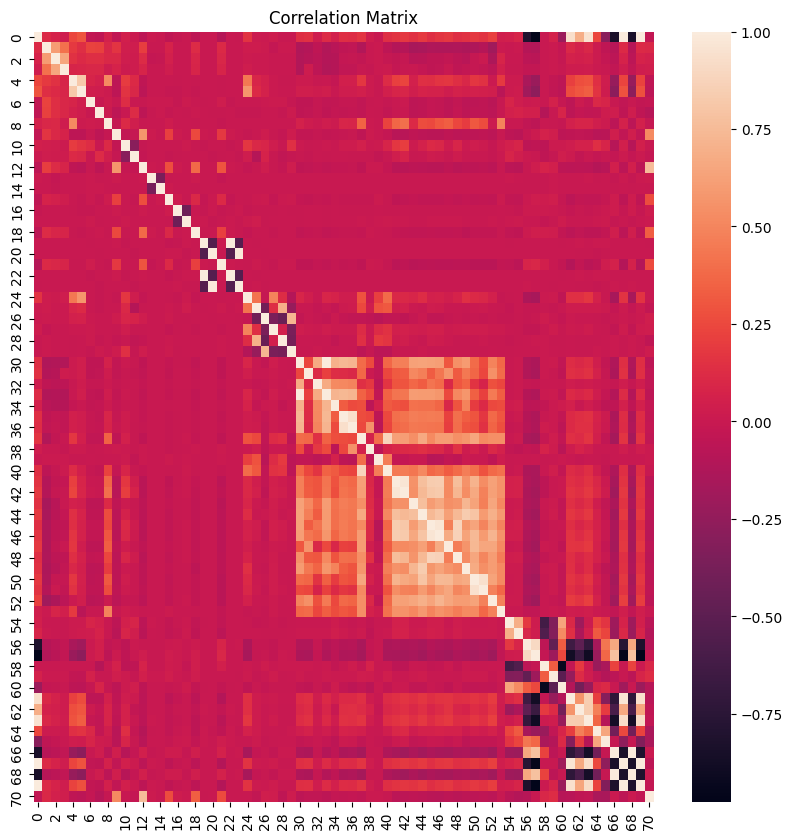

In [ ]:
train_data = np.vstack((X_proc.T,np.log(y/100+1)))
cor_matrix = np.corrcoef(train_data)

# Represent the correlation matrix with heatmap
fig1 = plt.figure(figsize=(10, 10))
fig1 = sns.heatmap(cor_matrix, annot=False)
fig1.set_title('Correlation Matrix')
plt.show()

In [ ]:
col_dict = {}
i = 0

for col in df5.columns:
    col_dict[i] = (col, cor_matrix[70,i])
    i += 1

col_dict

{0: ('year', -0.03160960420705554),
 1: ('Ticker', 0.10133205920278085),
 2: ('Industry', 0.05529133950930516),
 3: ('Sector', 0.03605348627353236),
 4: ('price', -0.045038514846319745),
 5: ('price_adjusted', -0.06300081815924773),
 6: ('price_diff1', -0.02025660842193246),
 7: ('price_diff1.1', -0.08139984410950028),
 8: ('market_cap', -0.011556132663420007),
 9: ('eps', 0.5214423104278725),
 10: ('eps_diff1', -0.006634178159408973),
 11: ('eps_dif2', -0.02150081520758338),
 12: ('per', 0.7553862243549447),
 13: ('per_diff1', 0.01898141710607373),
 14: ('per_diff2', -0.0044726665731037426),
 15: ('der', 0.25954968377529875),
 16: ('der_diff1', 0.021050041228322363),
 17: ('der_diff2', 0.005186172261104108),
 18: ('wcr', 0.32962604295566966),
 19: ('wcr_diff1', -0.0030738872790048227),
 20: ('wcr_diff2', -0.00016334069447912605),
 21: ('qr', 0.25818766764284695),
 22: ('qr_diff1', 0.0014515595536957935),
 23: ('qr_diff2', -0.0023700134409992083),
 24: ('fcfps', 0.0009989509223767403),

# 5. Generate the expanding window and save the data sets

In [ ]:
df6 = df5           # Just to work with df6

# All years between 2000 and 2021
for year in range(2000,2022):

    print(f'######  Data set for year {year}, in process...  #######')

    # Train set, instances 5 year before:
    df_train = df6[(df6['year'] < year)]
    print('Train set instances:',df_train.shape[0])

    # Test set, instances of year==year:
    df_test = df6[df6['year'] == year]
    print('Test set instances:',df_test.shape[0])

    # Divide features and target:
    X_train_df = df_train.iloc[:,0:-1]
    y_train = df_train['target']

    X_test_df = df_test.iloc[:,0:-1]
    y_test = df_test['target']

    # Fit the pipeline on the training data
    pipeline.fit(X_train_df, y_train)
    # Fit the pipeline and use it to fill the NA...
    X_train = pipeline.transform(X_train_df)
    X_test = pipeline.transform(X_test_df)

    # File names
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    np.savetxt(file_X_train, X_train, delimiter=',')
    np.savetxt(file_X_test, X_test, delimiter=',')
    np.savetxt(file_y_train, y_train, delimiter=',')
    np.savetxt(file_y_test, y_test, delimiter=',')